# Titanic Survival Prediction

## 1.) Introduction

This project will try to predict the likelihood of survival for passengers on the Titanic.

### 1A.) Import Libraries

In [1]:
import sklearn  # Machine learning library
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Data visualization
import numpy as np  # Linear Algebra
import pandas as pd  # Pandas for data frames
import warnings
from imblearn.over_sampling import SMOTE # Class rebalancing
from sklearn.ensemble import StackingClassifier  # Final ensemble model
from sklearn.ensemble import GradientBoostingClassifier # Gradient Boosting
from sklearn.neighbors import KNeighborsClassifier  # KNearestNeighbors
from sklearn.ensemble import RandomForestClassifier  # Random Forests
from sklearn.linear_model import LogisticRegression  # Logistic Regression
from sklearn.model_selection import train_test_split, cross_val_score # Splitting training and validation data
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import roc_curve  # ROC curve plotting
from sklearn.feature_selection import RFECV # Recursive feature cross validation
from sklearn.metrics import classification_report  # Classification report matrix
from sklearn.preprocessing import power_transform  # Box cox transformation
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score

# Future Warning in front of plots was annoying.
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set(style="whitegrid")
sns.set_context(context=None, font_scale=1, rc=None)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 24

## 2.) Loading Data

In [2]:
titanic = pd.read_csv('train.csv')  # Read in training dataset
test = pd.read_csv('test.csv')  # Read in testing dataset

# Functions to make life easier

In [3]:
def make_probability_chart(dataframe, target, column):
    """Makes a bar chart showing survival rate by target variable"""
    f, ax = plt.subplots(figsize=(12, 8))
    dataframe.groupby([column])[target].mean().plot(kind='bar')
    plt.title(f'{target} by {column}')
    plt.ylabel(f"Probability of {target}")
    xvals = ax.get_xticks()
    yvals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in yvals])
    f.autofmt_xdate()
    plt.show()

# Features Engineered

In [4]:
titanic['Salutation'] = titanic['Name'].str.extract('([A-Za-z]+)\.')
test['Salutation'] = test['Name'].str.extract('([A-Za-z]+)\.')

titanic['With_family'] = titanic['SibSp'] + titanic['Parch']
test['With_family'] = test['SibSp'] + titanic['Parch']

titanic['7+'] = titanic['With_family'] > 7
test['7+'] = test['With_family'] >= 7

titanic['Deck'] = titanic['Cabin'].str[0]
test['Deck'] = test['Cabin'].str[0]

titanic['Age'] = titanic.groupby("Salutation")["Age"].transform(
    lambda x: x.fillna(x.median()))
test['Age'] = test.groupby("Salutation")["Age"].transform(
    lambda x: x.fillna(titanic['Age'].median()))
test['Age'] = test['Age'].fillna(np.median(titanic['Age']))

## 3.) Exploratory Data Analysis

### 3A.) First Glance

In [5]:
# First few rows
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Salutation,With_family,7+,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1,False,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1,False,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,False,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1,False,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0,False,NaN


In [6]:
# Shape of dataset (rows, columns)
titanic.shape

(891, 16)

### 3B.) Survived

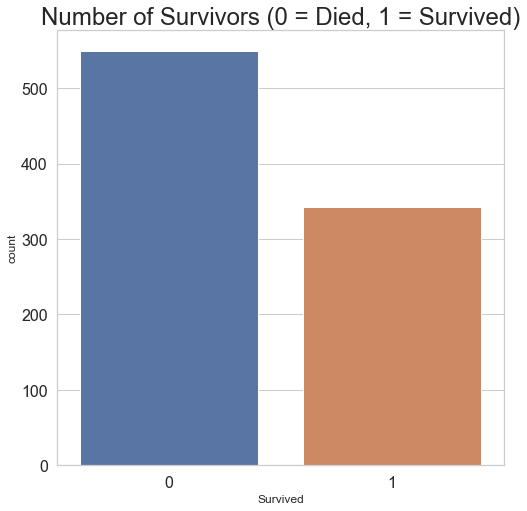

In [7]:
# Create a bar chart showing number of survivors.
f, ax = plt.subplots(figsize=(8, 8))
nsurvivors = sns.countplot(titanic['Survived']).set_title(
    'Number of Survivors (0 = Died, 1 = Survived)')
plt.show()

### 3C.) Passenger Class

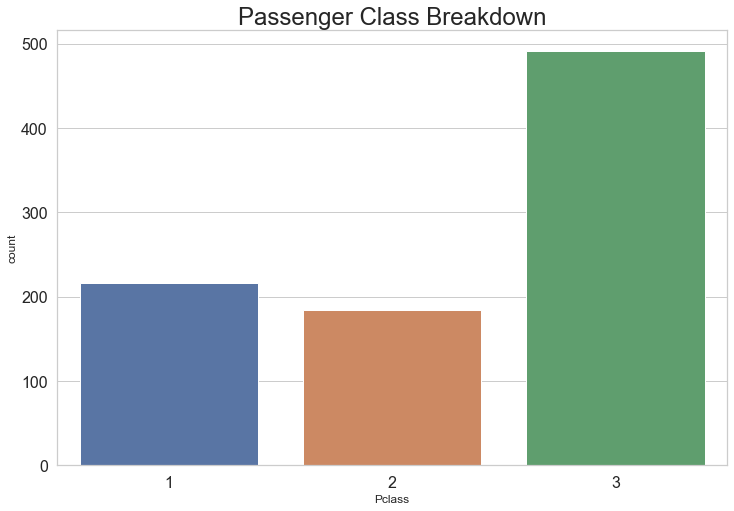

In [8]:
# Updating Color Palatte

plt.subplots(figsize=(12, 8))
sns.countplot(titanic['Pclass']).set_title('Passenger Class Breakdown')
plt.show()

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


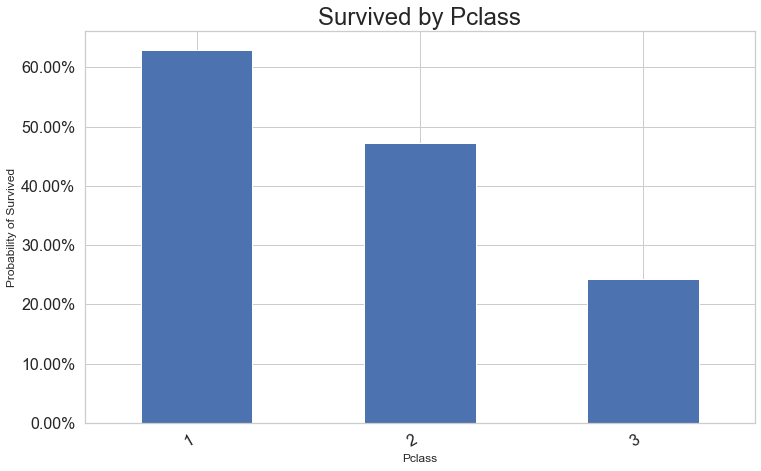

In [9]:
make_probability_chart(titanic, "Survived", "Pclass")

### 3D.) Name

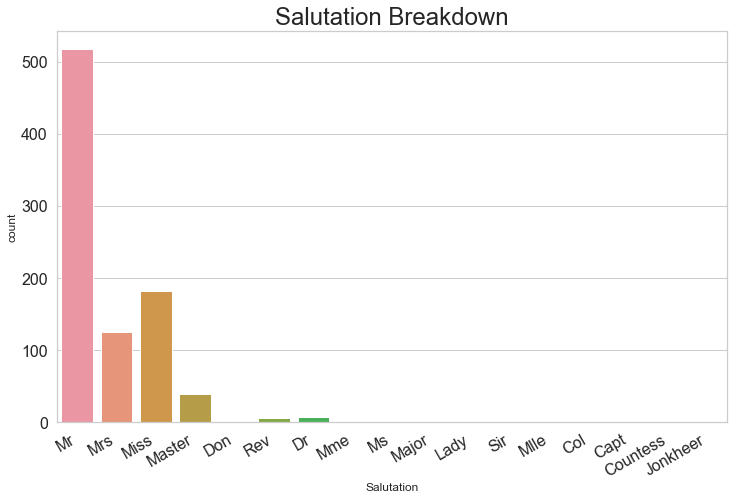

In [10]:
f, ax = plt.subplots(figsize=(12, 8))
sns.countplot(titanic['Salutation']).set_title('Salutation Breakdown')
f.autofmt_xdate()
plt.show()

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


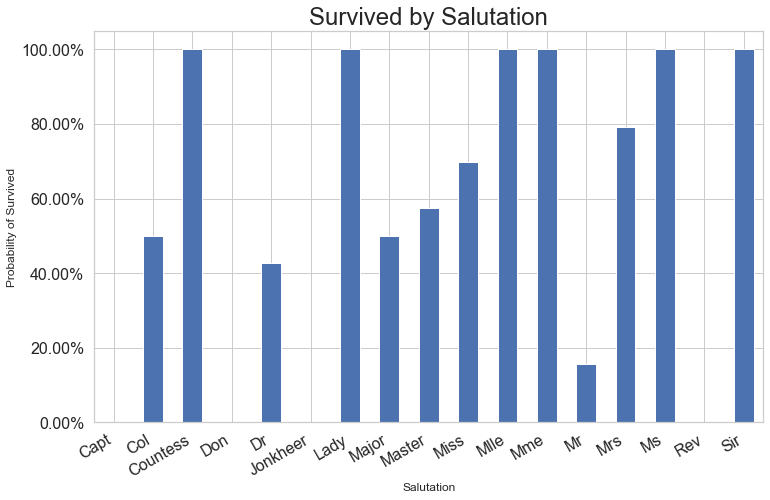

In [11]:
make_probability_chart(titanic, "Survived", "Salutation")

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


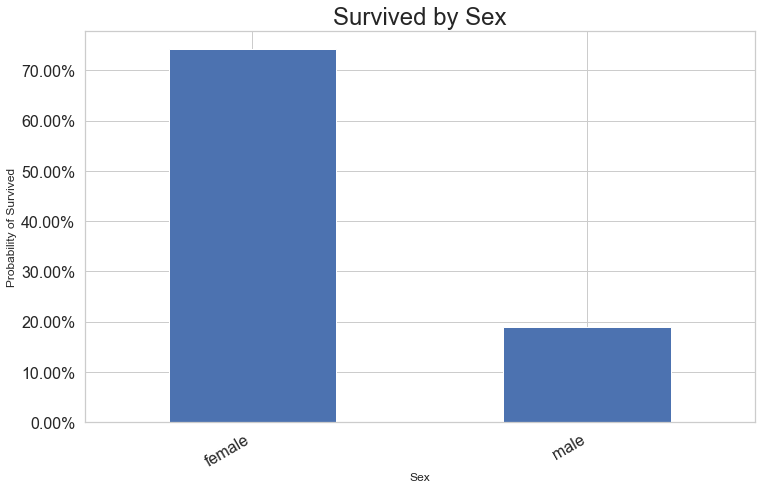

In [12]:
make_probability_chart(titanic, "Survived", "Sex")

### 3F.) Age

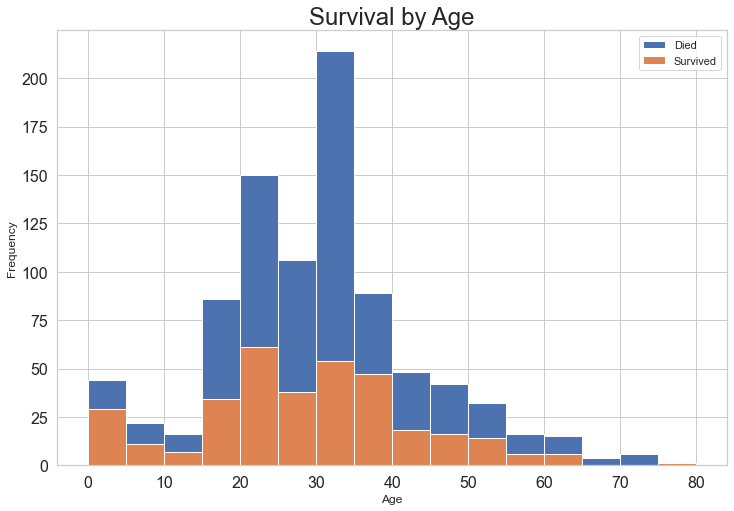

In [13]:
# Create a stacked histogram to show survival by age.
f, ax = plt.subplots(figsize=(12, 8))
titanic['Age'].plot.hist(bins=range(0, 85, 5))
age_plot = titanic[titanic['Survived'] ==
                   1]['Age'].plot.hist(bins=range(0, 85, 5))
age_plot.legend(['Died', 'Survived'])
age_plot.set_title('Survival by Age')
age_plot.set_xlabel('Age')
plt.show()

### 3G.) Family

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


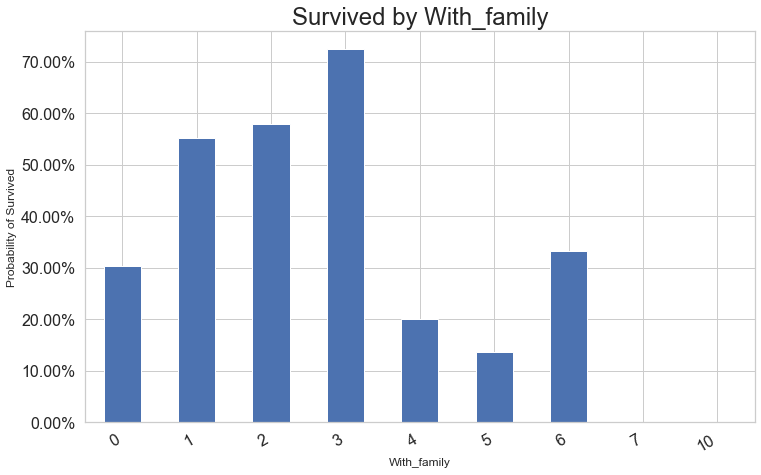

In [14]:
# Combining siblings and parents into family

make_probability_chart(titanic, "Survived", "With_family")

### 3H.) Cabin

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


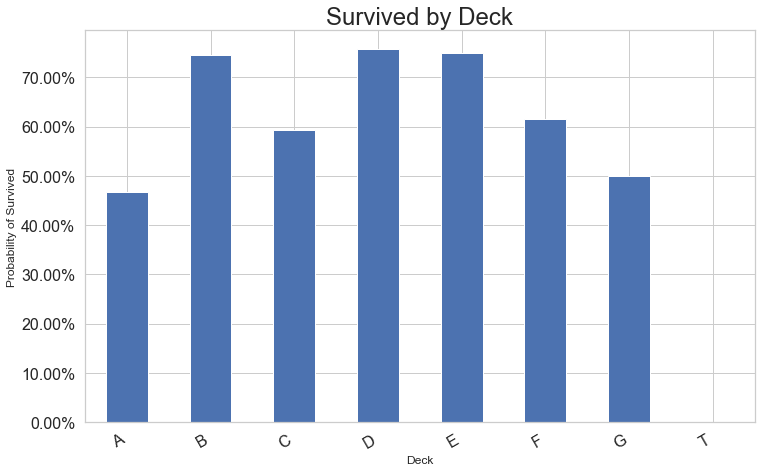

In [15]:
# Replaced cabins with a deck. NaNs for level have 'n'.
make_probability_chart(titanic, "Survived", "Deck")

### 3I.) Fare

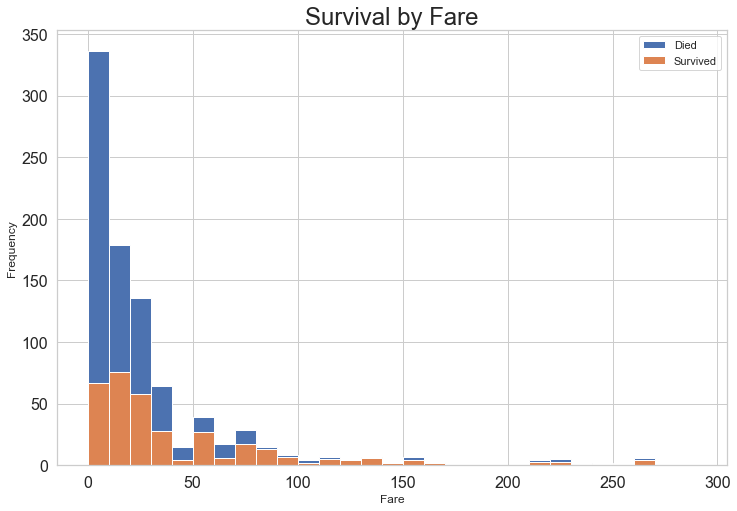

In [16]:
# Create a stacked histogram to show survival by age.
f, ax = plt.subplots(figsize=(12, 8))
titanic['Fare'].plot.hist(bins=range(0, 300, 10))
age_plot = titanic[titanic['Survived'] ==
                   1]['Fare'].plot.hist(bins=range(0, 300, 10))
age_plot.legend(['Died', 'Survived'])
age_plot.set_title('Survival by Fare')
age_plot.set_xlabel('Fare')
plt.show()

### 3J.) Embarked

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


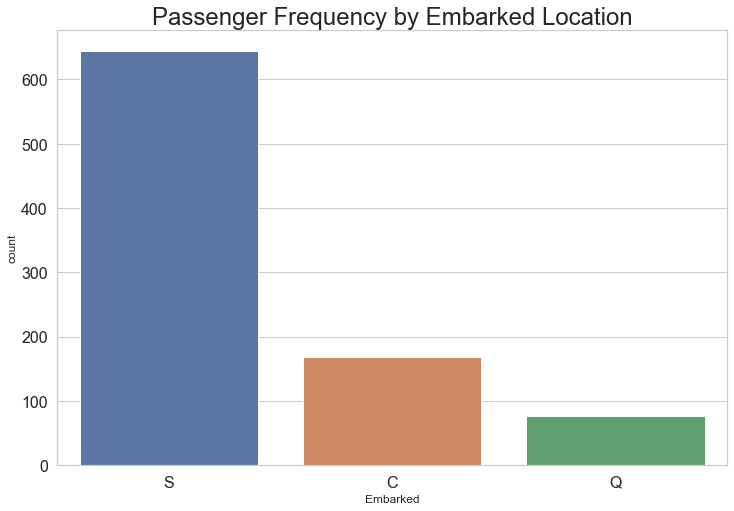

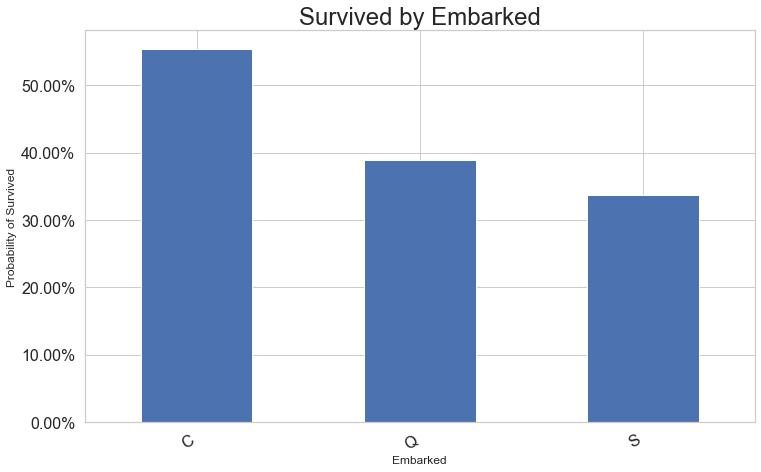

In [17]:
f, ax = plt.subplots(figsize=(12, 8))
sns.countplot(titanic['Embarked']).set_title(
    'Passenger Frequency by Embarked Location')
make_probability_chart(titanic, "Survived", "Embarked")

## 4.) Filling in Missing Values

### 4A.) Figure out what is missing

In [18]:
print("Training Data")
print(titanic.isnull().sum())
print('\n')
print("Testing Data")
print(test.isnull().sum())

Training Data
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Salutation       0
With_family      0
7+               0
Deck           687
dtype: int64


Testing Data
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Salutation       0
With_family      0
7+               0
Deck           327
dtype: int64


### 4B.) Age

In [74]:
age_by_salutation = titanic.groupby('Salutation')['Age'].mean()

Salutation
Master     4.466750
Miss      21.620879
Mr        31.823017
Mrs       35.776000
Other     42.537037
Name: Age, dtype: float64

In [20]:
titanic['Age'] = titanic.groupby("Salutation")["Age"].transform(
    lambda x: x.fillna(x.median()))
test['Age'] = titanic.groupby("Salutation")["Age"].transform(
    lambda x: x.fillna(titanic['Age'].median()))


titanic['Age_Bucket'] = pd.cut(
    titanic['Age'], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 90])
test['Age_Bucket'] = pd.cut(
    titanic['Age'], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 90])

### 4C.) Deck

In [21]:
# Replaced cabins with a cabin level. NaNs for level have 'n'.
titanic['Deck'] = titanic['Deck'].fillna('N')
test['Deck'] = test['Deck'].fillna('N')

# There is no deck 'T' on the Titanic, so replacing that with 'N':
titanic[titanic['Deck'] == 'T'] = titanic[titanic['Deck'] == 'T'].replace('T', 'N')
test[test['Deck'] == 'T'] = test[test['Deck'] == 'T'].replace('T', 'N')

### 4D.) Fare

In [22]:
# Fill the one NA in test with the fare median
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

titanic['Fare'] = pd.cut(titanic['Fare'], bins=[0, 25, 50, 100, 250])
test['Fare'] = pd.cut(test['Fare'], bins=[0, 25, 50, 100, 250])

### 4E.) Embarked

In [23]:
titanic['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [24]:
# According to Encyclopedia Titanica, both of the null passengers embarked at Southampton.
# https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html
titanic['Embarked'].fillna('S', inplace=True)

### 4F.) Sanity Check

In [25]:
# Sanity check to make sure all missing values are taken care of. Cabin won't be in any of the models, so we're good.
titanic.isnull().sum()
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare            10
Cabin          327
Embarked         0
Salutation       0
With_family      0
7+               0
Deck             0
Age_Bucket       0
dtype: int64

## 5.) Model Preparations

### 5A.) Drop Columns

In [26]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    object  
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         867 non-null    category
 10  Cabin        204 non-null    object  
 11  Embarked     891 non-null    object  
 12  Salutation   891 non-null    object  
 13  With_family  891 non-null    int64   
 14  7+           891 non-null    bool    
 15  Deck         891 non-null    object  
 16  Age_Bucket   891 non-null    category
dtypes: bool(1), category(2), float64(1), int64(6), object(7)
memory usage: 10

In [27]:
top_four = titanic['Salutation'].value_counts().nlargest(4).index
titanic['Salutation'] = titanic['Salutation'].where(
    titanic['Salutation'].isin(top_four), other="Other")
test['Salutation'] = titanic['Salutation'].where(
    test['Salutation'].isin(top_four), other="Other")

In [29]:
# Dropping columns not needed in the model.
X_train = titanic.drop(['Survived', 'PassengerId', 'Name', 'Cabin',
                        'Ticket', 'With_family', 'Age'], 1)  # 1 is to specify columns
y_train = titanic['Survived']
X_test = test.drop(['PassengerId', 'Cabin', 'Name',
                    'Ticket', 'With_family', 'Age'], 1)

In [30]:
X_train['Pclass'] = X_train['Pclass'].astype("category")
X_test['Pclass'] = X_train['Pclass'].astype("category")

### 5B.) Add Dummy Variables

In [32]:
# Fit and transform categorical variables to integers
X = pd.get_dummies(X_train, columns=[
                   'Sex', 'Embarked', 'Salutation', 'Deck', 'Age_Bucket', 'Fare'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=[
                        'Sex', 'Embarked', 'Salutation', 'Deck', 'Age_Bucket', 'Fare'], drop_first=True)
column_names = list(X.columns)

In [33]:
import statsmodels.api as sm
y = titanic['Survived']
logreg_sm = sm.Logit(y.astype(float), X.astype(float)).fit()
print(logreg_sm.summary())

         Current function value: 0.410224
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      858
Method:                           MLE   Df Model:                           32
Date:                Sun, 08 Nov 2020   Pseudo R-squ.:                  0.3840
Time:                        07:50:49   Log-Likelihood:                -365.51
converged:                      False   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 2.171e-76
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Pclass                 -0.4545      0.204     -2.224      0.026      -0.855      -0.054
SibSp                  -0.5478      0.

C:\Users\Tom\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [34]:
X['7+'] = X['7+'].map({False: 0, True: 1})
X_test['7+'] = X_test['7+'].map({False: 0, True: 1})

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(
    X.values, i) for i in range(len(X.columns))]

print(vif_data)

                feature        VIF
0                Pclass  32.330494
1                 SibSp   3.203631
2                 Parch   1.965751
3                    7+   1.923719
4              Sex_male  48.723701
5            Embarked_Q   1.743137
6            Embarked_S   5.505409
7       Salutation_Miss  19.497836
8         Salutation_Mr  32.659421
9        Salutation_Mrs  16.458485
10     Salutation_Other   2.602115
11               Deck_B   3.729448
12               Deck_C   4.599337
13               Deck_D   2.952413
14               Deck_E   2.953574
15               Deck_F   1.889479
16               Deck_G   1.372495
17               Deck_N  50.669145
18   Age_Bucket_(5, 10]   1.467341
19  Age_Bucket_(10, 15]   1.648723
20  Age_Bucket_(15, 20]   5.594139
21  Age_Bucket_(20, 25]   8.345893
22  Age_Bucket_(25, 30]  12.930058
23  Age_Bucket_(30, 35]   6.573842
24  Age_Bucket_(35, 40]   4.425400
25  Age_Bucket_(40, 45]   3.500214
26  Age_Bucket_(45, 50]   3.202407
27  Age_Bucket_(50, 

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_test.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_test.values, i) for i in range(len(X_test.columns))]

print(vif_data)

                feature        VIF
0                Pclass   9.721033
1                 SibSp   2.416561
2                 Parch   1.451606
3                    7+   1.783229
4              Sex_male   3.075451
5            Embarked_Q   1.743388
6            Embarked_S   4.347652
7       Salutation_Miss   9.176222
8         Salutation_Mr  25.093590
9        Salutation_Mrs   7.322995
10     Salutation_Other   2.406928
11               Deck_B   2.056131
12               Deck_C   3.798082
13               Deck_D   1.897563
14               Deck_E   1.831994
15               Deck_F   1.612611
16               Deck_G   1.075088
17               Deck_N  22.158422
18   Age_Bucket_(5, 10]   1.273836
19  Age_Bucket_(10, 15]   1.427836
20  Age_Bucket_(15, 20]   4.605197
21  Age_Bucket_(20, 25]   7.214602
22  Age_Bucket_(25, 30]   9.826908
23  Age_Bucket_(30, 35]   4.876699
24  Age_Bucket_(35, 40]   3.691685
25  Age_Bucket_(40, 45]   3.107047
26  Age_Bucket_(45, 50]   1.876319
27  Age_Bucket_(50, 

In [37]:
X = X.drop(['Deck_N', 'Salutation_Mr', 'Sex_male', 'Pclass'], 1)
X_test = X_test.drop(
    ['Deck_N', 'Salutation_Mr', 'Sex_male', 'Pclass'], 1)

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(
    X.values, i) for i in range(len(X.columns))]

print(vif_data)

                feature       VIF
0                 SibSp  2.777863
1                 Parch  1.820643
2                    7+  1.828952
3            Embarked_Q  1.593957
4            Embarked_S  4.789395
5       Salutation_Miss  1.564850
6        Salutation_Mrs  1.528996
7      Salutation_Other  1.163578
8                Deck_B  1.465362
9                Deck_C  1.534873
10               Deck_D  1.303543
11               Deck_E  1.217295
12               Deck_F  1.029020
13               Deck_G  1.035993
14   Age_Bucket_(5, 10]  1.270385
15  Age_Bucket_(10, 15]  1.129679
16  Age_Bucket_(15, 20]  1.571823
17  Age_Bucket_(20, 25]  2.020399
18  Age_Bucket_(25, 30]  2.176458
19  Age_Bucket_(30, 35]  1.751589
20  Age_Bucket_(35, 40]  1.502469
21  Age_Bucket_(40, 45]  1.404684
22  Age_Bucket_(45, 50]  1.352978
23  Age_Bucket_(50, 55]  1.275439
24  Age_Bucket_(55, 60]  1.152200
25  Age_Bucket_(60, 90]  1.206857
26        Fare_(25, 50]  1.804730
27       Fare_(50, 100]  2.114484
28      Fare_(

In [38]:
assert len(X_test.columns) == len(X.columns)

### 5C.) Split Titanic Data into Training and Validation Model

In [39]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X, titanic['Survived'], test_size=0.3, random_state=42)

## 6.) Modeling and Verifying Model

### 6A.) Logistic Regression

In [41]:
logreg = LogisticRegression(penalty='l2')
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_validation)
print(classification_report(y_validation, y_pred_log))

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict(X_validation)
y_pred_proba = logreg.predict_proba(X_validation)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba)

print("Accuracy score:", accuracy_score(y_validation, y_pred_prob))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       157
           1       0.76      0.70      0.73       111

    accuracy                           0.79       268
   macro avg       0.78      0.77      0.78       268
weighted avg       0.79      0.79      0.79       268

Accuracy score: 0.7873134328358209


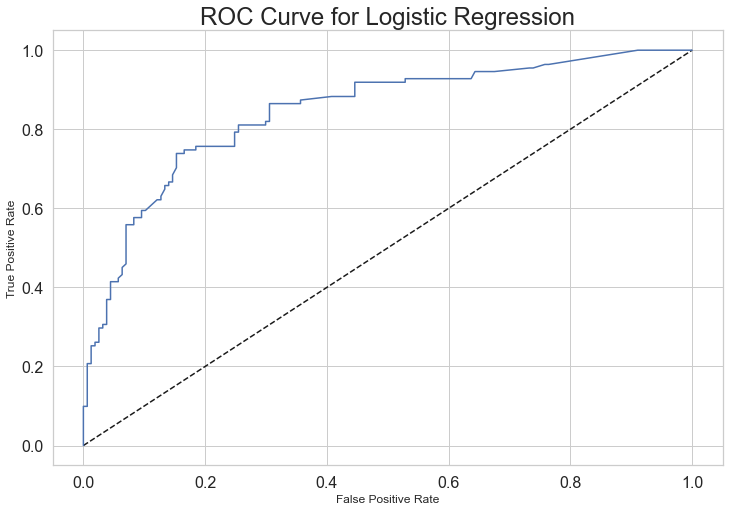

In [42]:
# Plot ROC curve
f, ax = plt.subplots(figsize=(12, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.show()

Optimal number of features: 26


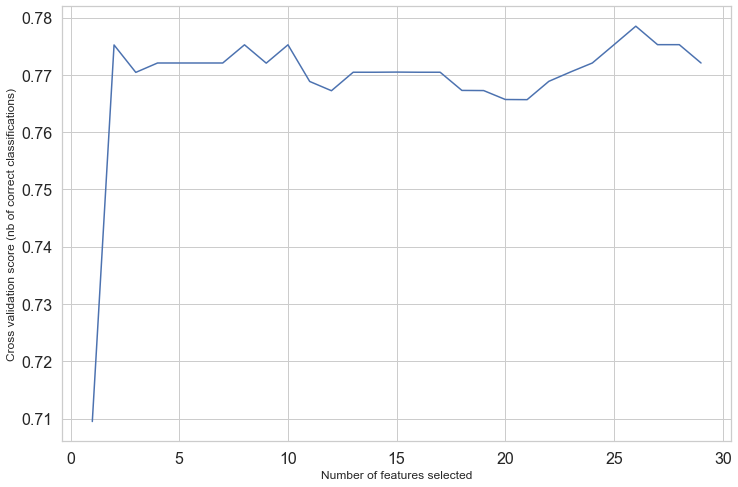

In [43]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(),
              step=1, cv=10, scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features: %d" % rfecv.n_features_)

plt.figure(figsize=(12, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

### 6B.) Random Forest

In [44]:
random_forest = RandomForestClassifier(n_estimators=1000)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_validation)
print(classification_report(y_validation, y_pred_rf))

# Compute predicted probabilities: y_pred_prob
y_pred_prob = random_forest.predict(X_validation)
y_pred_proba = random_forest.predict_proba(X_validation)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba)

print("Accuracy score:", accuracy_score(y_validation, y_pred_prob))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       157
           1       0.76      0.73      0.74       111

    accuracy                           0.79       268
   macro avg       0.79      0.78      0.78       268
weighted avg       0.79      0.79      0.79       268

Accuracy score: 0.7910447761194029


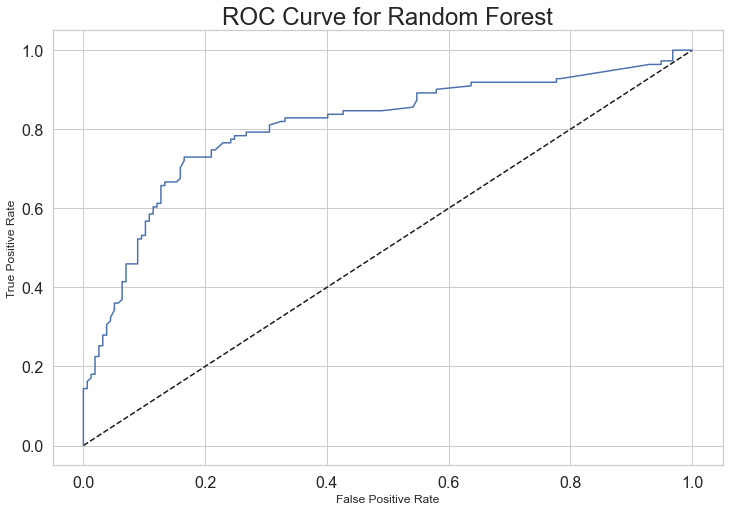

In [45]:
plt.figure(figsize=(12, 8))
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.show()

In [46]:
# Create the parameter grid
rf = RandomForestClassifier()
param_grid = {'n_estimators': [100],
              'max_depth': [x for x in range(3, 10)],
              'min_samples_leaf': [x for x in range(3, 20)],
              'max_features': ['sqrt', 'log2', .2]
              }

gridsearch = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_jobs=-1,
                                verbose=5, return_train_score=True, cv=5, n_iter=100)

y_pred_gridsearch = gridsearch.fit(X_train, y_train).predict(X_validation)
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_prob)
print(classification_report(y_validation, y_pred_gridsearch))
print("Accuracy score:", accuracy_score(y_validation, y_pred_gridsearch))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   38.7s finished


              precision    recall  f1-score   support

           0       0.78      0.87      0.82       157
           1       0.78      0.66      0.71       111

    accuracy                           0.78       268
   macro avg       0.78      0.76      0.77       268
weighted avg       0.78      0.78      0.78       268

Accuracy score: 0.7798507462686567


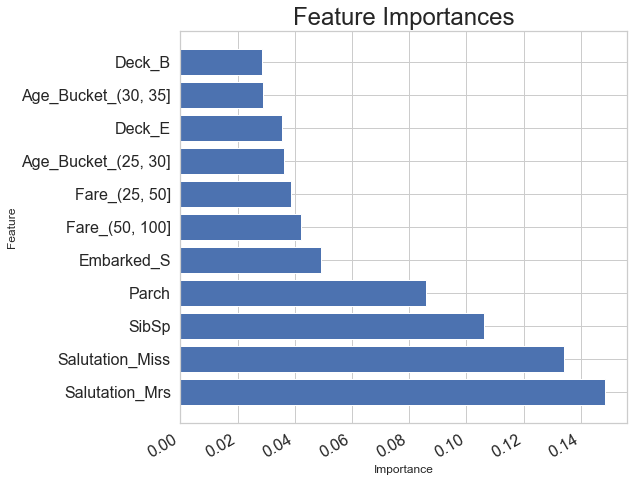

In [47]:
feature_importances = pd.DataFrame(zip(list(X.columns), random_forest.feature_importances_), columns=(
    "Feature", "Importance")).sort_values(by="Importance", ascending=False)[0:11]
f, ax = plt.subplots(figsize=(8, 8))
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.barh(feature_importances["Feature"], feature_importances["Importance"])
f.autofmt_xdate()
plt.show()

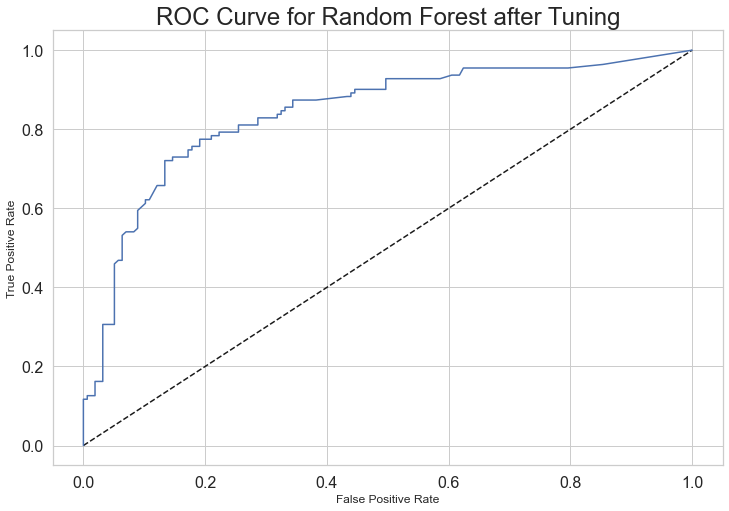

In [48]:
y_pred_proba = gridsearch.predict_proba(X_validation)[:, 1]
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba)
plt.figure(figsize=(12, 8))
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest after Tuning')
plt.show()

### 6C.) K-Nearest Neighbors 

In [49]:
param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]}
knn = sklearn.neighbors.KNeighborsClassifier()
knn_gridsearch = GridSearchCV(
    knn, param_grid=param_grid, n_jobs=-1, verbose=5, return_train_score=True, cv=5)
y_pred = knn_gridsearch.fit(X_train, y_train).predict(X_validation)
y_pred_proba = knn_gridsearch.predict_proba(X_validation)[:, 1]
# Generate ROC curve values: fpr, tpr, thresholds

fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba)
print(classification_report(y_validation, y_pred_gridsearch))
print("Accuracy score:", accuracy_score(y_validation, y_pred))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.3s


              precision    recall  f1-score   support

           0       0.78      0.87      0.82       157
           1       0.78      0.66      0.71       111

    accuracy                           0.78       268
   macro avg       0.78      0.76      0.77       268
weighted avg       0.78      0.78      0.78       268

Accuracy score: 0.7574626865671642


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.3s finished


In [50]:
knn_gridsearch.best_params_

{'n_neighbors': 7}

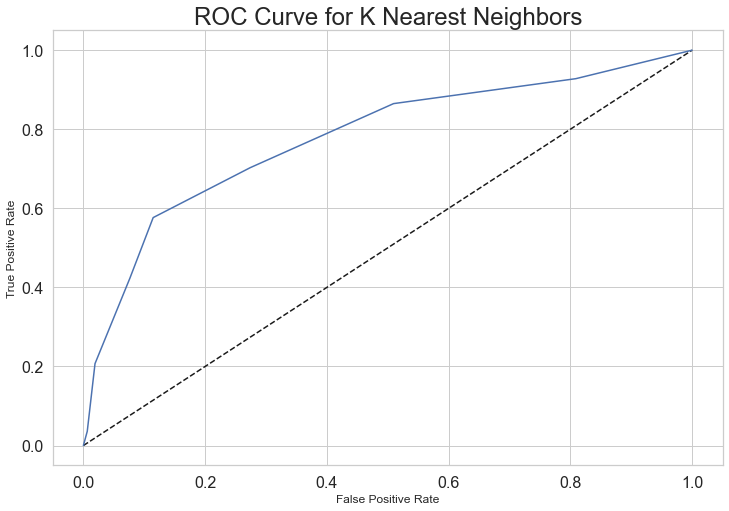

In [51]:
# Plot ROC curve

y_pred_proba = knn_gridsearch.predict_proba(X_validation)[:, 1]
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba)
plt.figure(figsize=(12, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for K Nearest Neighbors')
plt.show()

In [52]:
param_grid = {'learning_rate': np.linspace(.01, .3, 30),
              'max_depth': [x for x in range(2, 20)],
              'n_estimators': [100],
              'max_features': [.2, 'sqrt', 'log2'],
              'warm_start': [True]
              }
gbm = GradientBoostingClassifier()
gbm_random_search = RandomizedSearchCV(gbm,
                                       param_distributions=param_grid,
                                       scoring='accuracy',
                                       n_jobs=-1,
                                       verbose=5,
                                       n_iter=25,
                                       cv=5,
                                       return_train_score=True
                                       )

predictions = gbm_random_search.fit(X_train, y_train).predict(X_validation)
fpr, tpr, thresholds = roc_curve(y_validation, predictions)
print(classification_report(y_validation, predictions))
print("Accuracy score:", accuracy_score(y_validation, predictions))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   16.0s


              precision    recall  f1-score   support

           0       0.80      0.85      0.83       157
           1       0.77      0.70      0.74       111

    accuracy                           0.79       268
   macro avg       0.79      0.78      0.78       268
weighted avg       0.79      0.79      0.79       268

Accuracy score: 0.7910447761194029


[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   29.4s finished


In [53]:
print(gridsearch.best_params_)
print(knn_gridsearch.best_params_)
print(gbm_random_search.best_params_)

{'n_estimators': 100, 'min_samples_leaf': 10, 'max_features': 0.2, 'max_depth': 9}
{'n_neighbors': 7}
{'warm_start': True, 'n_estimators': 100, 'max_features': 'log2', 'max_depth': 3, 'learning_rate': 0.27999999999999997}


## 7.) Conclusion

In [54]:
classifier1 = LogisticRegression()
classifier2 = RandomForestClassifier(max_depth=gridsearch.best_params_['max_depth'], min_samples_leaf=gridsearch.best_params_['min_samples_leaf'], n_estimators=1000)
classifier3 = KNeighborsClassifier(n_neighbors=knn_gridsearch.best_params_['n_neighbors'])
classifier4 = GradientBoostingClassifier(n_estimators=1000, max_features=gbm_random_search.best_params_['max_features'], max_depth=gbm_random_search.best_params_['max_depth'], learning_rate=gbm_random_search.best_params_['learning_rate'])
sclf = StackingClassifier(estimators=[('lr', classifier1), ('rf', classifier2), ('knn', classifier3), ('gbm', classifier4)]).fit(X, titanic['Survived'])
final_predictions = classifier2.fit(X, y).predict(X_test)

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       157
           1       0.78      0.70      0.74       111

    accuracy                           0.79       268
   macro avg       0.79      0.78      0.79       268
weighted avg       0.79      0.79      0.79       268

Accuracy score: 0.7947761194029851


Text(0.5, 1.0, 'ROC Curve for Stacking Classifier')

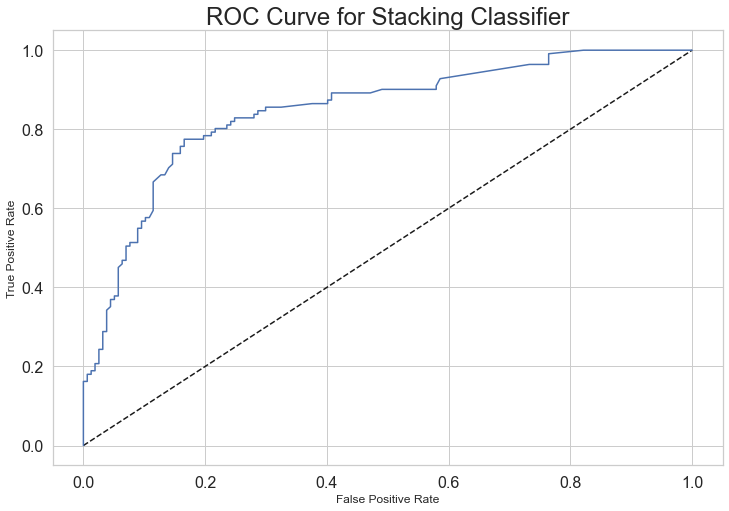

In [55]:
y_sclf = sclf.fit(X_train, y_train).predict(X_validation)
y_sclf_proba = sclf.fit(X_train, y_train).predict_proba(X_validation)[:, 1]
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_validation, y_sclf_proba)
print(classification_report(y_validation, y_sclf))
print("Accuracy score:", accuracy_score(y_validation, y_sclf))

plt.figure(figsize=(12, 8))
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Stacking Classifier')

In [70]:
final_prediction_stack = sclf.fit(X, y).predict(X_test)

In [71]:
final_predictions = pd.DataFrame(final_prediction_stack, index=test['PassengerId'], columns=['Survived']).to_csv("Predictions.csv")